# Importing the libraries

In [ ]:
import torch
import numpy as np

import PIL # cv2 is better

In [ ]:
import pickle

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler


from matplotlib import colors, pyplot as plt
%matplotlib inline

from matplotlib import gridspec

# Selecting random seed

In [ ]:
# fix random seed
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Uploading data

In [ ]:
#pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVSIXW8/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVSIXW8/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
# dataset modes
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to the size of 224x224 px
RESCALE_SIZE = 256
# device setting
DEVICE = torch.device("cuda")

In [ ]:
train_val_data = list(dataset['train'])

In [ ]:
test_data = list(dataset['test'])

In [ ]:
micro_images = []
micro_masks = []
for i in range(int(len(train_val_data) * 0.25)):
  micro_images.append(train_val_data[i]['image'])
  micro_masks.append(train_val_data[i]['segmentation_mask'])

In [ ]:
train_images = []
train_masks = []
for i in range(int(len(train_val_data) * 0.75)):
  train_images.append(train_val_data[i]['image'])
  train_masks.append(train_val_data[i]['segmentation_mask'])

In [ ]:
val_images = []
val_masks = []
for i in range(int(len(train_val_data) * 0.75), len(train_val_data)):
  val_images.append(train_val_data[i]['image'])
  val_masks.append(train_val_data[i]['segmentation_mask'])

In [ ]:
test_images = []
test_masks = []
for i in range(len(test_data)):
  test_images.append(test_data[i]['image'])
  test_masks.append(test_data[i]['segmentation_mask'])

# Dataset

In [ ]:
class AnimalsDataset(Dataset):
    """
    Dataset with images and segmentation masks, allowing separate lists for images and masks
    """
    def __init__(self, images, masks, mode):
        super().__init__()
        # dataset mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(images)
        self.images = images
        self.masks = masks

        self.transform_img = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.transform_mask = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        if self.mode == 'test':
            image_path = self.images[index]
            x = self.load_sample_image(image_path)
            x = self.transform_img(x)
            return x
        else:
            image_path = self.images[index]
            mask_path = self.masks[index]
            x = self.load_sample_image(image_path)
            y = self.load_sample_mask(mask_path)
            x = self.transform_img(x)
            y = (transforms.ToTensor()(y) * 255).type(torch.uint8)
            y = transforms.Resize((RESCALE_SIZE, RESCALE_SIZE))(y)
            return x, y[0] - 1

    def load_sample_image(self, tensor):
        if tensor.shape[-1] == 1:
          tensor = np.squeeze(tensor, axis=-1)  # Squeeze out the single channel dimension
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor)>3:
          assert tensor.shape[0] == 1
          tensor = tensor[0]
        image = PIL.Image.fromarray(tensor).convert('RGB')
        return image

    def load_sample_mask(self, tensor):
        if tensor.shape[-1] == 1:
          tensor = np.squeeze(tensor, axis=-1)  # Squeeze out the single channel dimension
        tensor = np.array(tensor, dtype=np.uint8)
        tensor = np.array(list(tensor))
        if np.ndim(tensor)>3:
          assert tensor.shape[0] == 1
          tensor = tensor[0]
        return tensor


    def append(self, new_image, new_mask):
      self.images.append(new_image)
      self.masks.append(new_mask)
      self.len_ += 1

# Showing images

In [ ]:
def rgb_imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title, fontsize = 10)
    plt_ax.grid(False)

In [ ]:
def bw_imshow(img, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = img.detach().numpy()
    #inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title, fontsize = 10)
    plt_ax.grid(False)

In [ ]:
val_dataset = AnimalsDataset(val_images, val_masks, mode='val')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


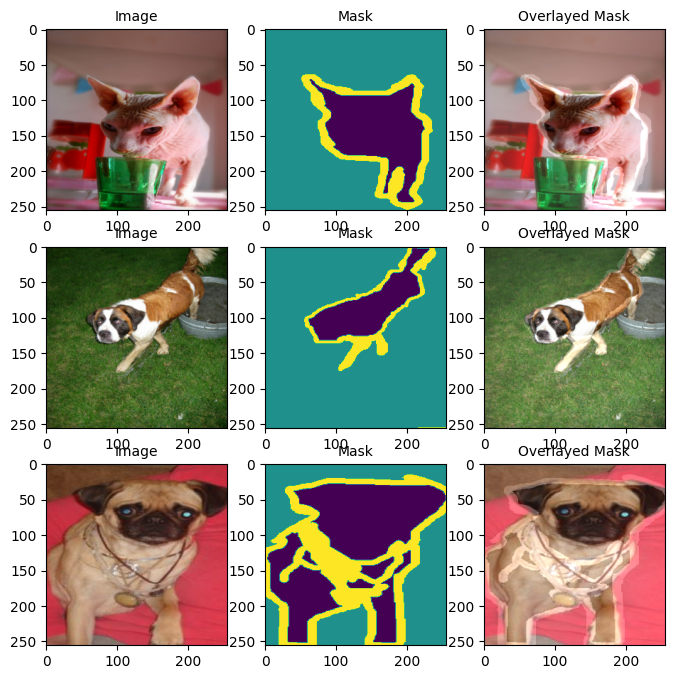

In [ ]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 3)
ax = np.empty([3, 3], dtype=object)
for i in range(3):
  for j in range(3):
    ax[i][j] = fig.add_subplot(gs[i, j])
for i in range(3):
  random_idx = int(np.random.uniform(0, len(val_dataset)))
  image, mask = val_dataset[random_idx]
  rgb_imshow(image, title="Image", plt_ax=ax[i][0])
  bw_imshow(mask, title="Mask", plt_ax=ax[i][1])
  normalized_mask = mask.float() / 255.0
  edit_mask = image + 150 * normalized_mask
  rgb_imshow(edit_mask, title="Overlayed Mask", plt_ax=ax[i][2])

# Data augmentation

In [ ]:
transform_image = transforms.Compose([
            transforms.ColorJitter(0.6, 0.6, 0.6, 0),
            transforms.RandomHorizontalFlip(1),
        ])
transform_mask = transforms.RandomHorizontalFlip(1)

In [ ]:
train_dataset = AnimalsDataset(train_images, train_masks, mode='train')

In [ ]:
len(train_dataset)

2760

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


RuntimeError: ignored

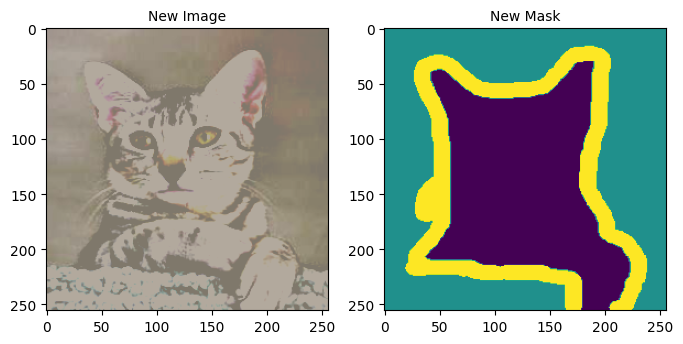

In [ ]:
for i in range(0, len(train_dataset) // 2):
  num_augs_per_img = 3
  num_added_imgs = 0
  random_idx = int(np.random.uniform(0, len(train_dataset) - 1))
  for j in range(num_augs_per_img):
    num_added_imgs += 1
    image, mask = train_dataset[random_idx]
    print(image.shape)

    new_image = transform_image(image)
    new_mask = transform_mask(mask)

    if i < 2:
      fig = plt.figure(figsize=(8, 8))
      gs = gridspec.GridSpec(1, 2)
      ax = np.empty([1, 2], dtype=object)
      ax[0][0] = fig.add_subplot(gs[0, 0])
      ax[0][1] = fig.add_subplot(gs[0, 1])
      print(new_image.shape)
      rgb_imshow(new_image, title="New Image", plt_ax=ax[0][0])
      bw_imshow(new_mask, title="New Mask", plt_ax=ax[0][1])
    new_image = new_image.permute(1, 2 ,0) # DO NOT WORK Correctly
    new_mask = new_mask.permute(1, 2, 0) # DO NOT WORK Correctly
    train_dataset.append(new_image, new_mask)
    if num_added_imgs >= 1:
      break

In [ ]:
len(train_dataset)

In [ ]:
img, msk = train_dataset[2760]
img.permute(2, 0, 1);
mask.permute(2, 0, 1);
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(1, 2)
ax = np.empty([1, 2], dtype=object)
ax[0][0] = fig.add_subplot(gs[0, 0])
ax[0][1] = fig.add_subplot(gs[0, 1])
rgb_imshow(img, title="New Image", plt_ax=ax[0][0])
bw_imshow(msk[0], title="New Mask", plt_ax=ax[0][1])

# Model

In [ ]:
class Model(nn.Module) :
  def __init__(self):
    super(Model, self).__init__()

    self.layers = torch.nn.Sequential()

    self.layers.add_module('conv1', torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1, stride=2))
    self.layers.add_module('norm1', torch.nn.BatchNorm2d(num_features=8))
    self.layers.add_module('relu1', torch.nn.ReLU())
    self.layers.add_module('dropout1', nn.Dropout2d(p=0.1))

    self.layers.add_module('conv2', torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, stride=2))
    self.layers.add_module('norm2', torch.nn.BatchNorm2d(num_features=16))
    self.layers.add_module('relu2', torch.nn.ReLU())
    self.layers.add_module('dropout2', nn.Dropout2d(p=0.1))

    self.layers.add_module('conv3', torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, stride=2))
    self.layers.add_module('norm3', torch.nn.BatchNorm2d(num_features=32))
    self.layers.add_module('relu3', torch.nn.ReLU())
    self.layers.add_module('dropout3', nn.Dropout2d(p=0.1))

    self.layers.add_module('conv4', torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, stride=2))
    self.layers.add_module('norm4', torch.nn.BatchNorm2d(num_features=64))
    self.layers.add_module('relu4', torch.nn.ReLU())
    self.layers.add_module('dropout4', nn.Dropout2d(p=0.1))

    self.layers.add_module('upconv1', torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, stride=2, output_padding=1))
    self.layers.add_module('norm5', torch.nn.BatchNorm2d(num_features=32))
    self.layers.add_module('relu5', torch.nn.ReLU())
    self.layers.add_module('dropout5', nn.Dropout2d(p=0.1))

    self.layers.add_module('upconv2', torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, stride=2, output_padding=1))
    self.layers.add_module('norm6', torch.nn.BatchNorm2d(num_features=16))
    self.layers.add_module('relu6', torch.nn.ReLU())
    self.layers.add_module('dropout6', nn.Dropout2d(p=0.1))

    self.layers.add_module('upconv3', torch.nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=1, stride=2, output_padding=1))
    self.layers.add_module('norm7', torch.nn.BatchNorm2d(num_features=8))
    self.layers.add_module('relu7', torch.nn.ReLU())
    self.layers.add_module('dropout7', nn.Dropout2d(p=0.1))

    self.layers.add_module('upconv4', torch.nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=(3, 3), padding=1, stride=2, output_padding=1))
    self.layers.add_module('softmax1', torch.nn.Softmax2d())


  def forward(self, input):
        return self.layers(input)

In [ ]:
my_model = Model()
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

Model(
  (layers): Sequential(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.1, inplace=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.1, inplace=False)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (dropout3): Dropout2d(p=0.1, inplace=False)
    (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU()
    (dropout4): Dropout2d(p=0.1, inplace=False)
    (upconv1)

# Model's layers before training

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change 

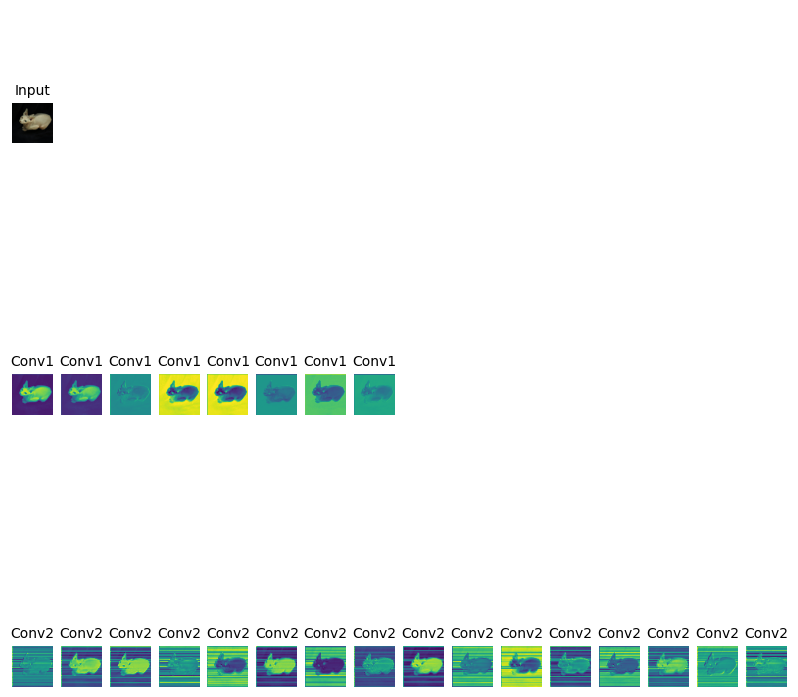

In [ ]:
img, mask = train_dataset[0]
x = img

layers = [0, 0, 0]
layers[0] = x
layers[1] = my_model.layers.conv1(x.cuda())
layers[2] = my_model.layers.conv2(my_model.layers.dropout1(my_model.layers.relu1(layers[1])))

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 16)
ax = np.empty([3, 16], dtype=object)
for i in range(3):
    for j in range(0, len(layers[i])):
        ax[i][j] = fig.add_subplot(gs[i, j])
        ax[i][j].axis("off")
rgb_imshow(x, title="Input", plt_ax=ax[0][0])
for i in range(1, 3):
  for j in range(0, len(layers[i])):
    layer_img = layers[i][j].cpu()
    bw_imshow(layer_img, title="Conv{}".format(i), plt_ax=ax[i][j])

# Training Template

In [ ]:
def jacard_acc(pred, true) :
    acc = 0
    for i in range(0, pred.shape[0]):
      delta_mask = torch.argmax(pred[i], 0) - true[i]
      logical_and = torch.logical_and(delta_mask, delta_mask)
      res = (logical_and == 0).sum().cpu().item()
      size = (delta_mask.shape[0] * delta_mask.shape[0])
      delta = res / (2 * size - res)
      acc += delta
    return acc

In [ ]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()

    output = model(x_batch.to(device))
    loss = loss_function(output, y_batch.to(device).long())
    loss.backward()

    accuracy = jacard_acc(output, y_batch)
    optimizer.step()
    return  (loss.cpu().item(), accuracy)

In [ ]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss, batch_acc = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)

        if callback is not None:
            callback(model, batch_loss, batch_acc)

        epoch_loss += batch_loss*len(batch_of_x)
        epoch_acc += batch_acc
        total += len(batch_of_x)

    return (epoch_loss/total, epoch_acc/total)

In [ ]:
def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan, 'train epoch acc': np.nan})

    history = [[1],[0]]
    for it in iterations:
        batch_generator = tqdm(torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        # print("Batches are generated")
        epoch_loss, epoch_acc = train_epoch(train_generator=batch_generator,
                    model=model,
                    loss_function=loss_function,
                    optimizer=optima,
                    callback=callback)
        history[0].append(epoch_loss)
        history[1].append(epoch_acc)

        #мб тут еще добавить
        iterations.set_postfix({'train epoch loss': epoch_loss, 'train epoch acc': epoch_acc})

    return history

# Trainig Model

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [ ]:
epoch_num = 30
batch_size = 10

In [ ]:
train_dataset = AnimalsDataset(train_images, train_masks, mode='train')

In [ ]:
history = trainer(epoch_num, batch_size, train_dataset, my_model, loss_function, optimizer)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

In [ ]:
torch.save(my_model, 'basic_model_30_epochs_copy.pkl')

# Showing the predictions

In [ ]:
def special_rgb_imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.cpu().numpy().transpose((1, 2, 0)) # transported to cpu
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title, fontsize = 10)
    plt_ax.grid(False)

In [ ]:
def special_bw_imshow(img, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = img.cpu().detach().numpy() # transported to cpu
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title, fontsize = 10)
    plt_ax.grid(False)

In [ ]:
def create_mask(pred) :
  mask = torch.argmax(pred, 1)
  return mask

In [ ]:
def pred_on_batch(model, x_batch):
    output = model(x_batch.to(device))
    return create_mask(output)

In [ ]:
def pred_epoch(batch_generator, model):
    for it, (batch_of_x, batch_of_y) in enumerate(batch_generator):
        output = pred_on_batch(model, batch_of_x.to(device))
        predict = {'img' : batch_of_x, 'mask' : batch_of_y, 'pred_mask' : output}
    return predict

In [ ]:
def predict(count_of_epoch,
            batch_size,
            dataset,
            model):

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    prediction = []
    for it in iterations:
        batch_generator = tqdm(torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True),
                               leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        prediction.append(pred_epoch(batch_generator,
                    model=model))
    return prediction

In [ ]:
def showing_images(prediction) :
  size = len(prediction['img'])
  # size = batch_size
  fig = plt.figure(figsize=(8, 8))
  gs = gridspec.GridSpec(size, 3)
  ax = np.empty([size, 3], dtype=object)
  for i in range(size):
    for j in range(3):
      ax[i][j] = fig.add_subplot(gs[i, j])
      ax[i][j].axis("off")
  for i in range(size):
    special_rgb_imshow(prediction['img'][i], plt_ax=ax[i][0])
    special_bw_imshow(prediction['mask'][i], plt_ax=ax[i][1])
    special_bw_imshow(prediction['pred_mask'][i], plt_ax=ax[i][2])


In [ ]:
prediction = predict(5, 5, train_dataset, my_model)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

In [ ]:
# micro_dataset.masks

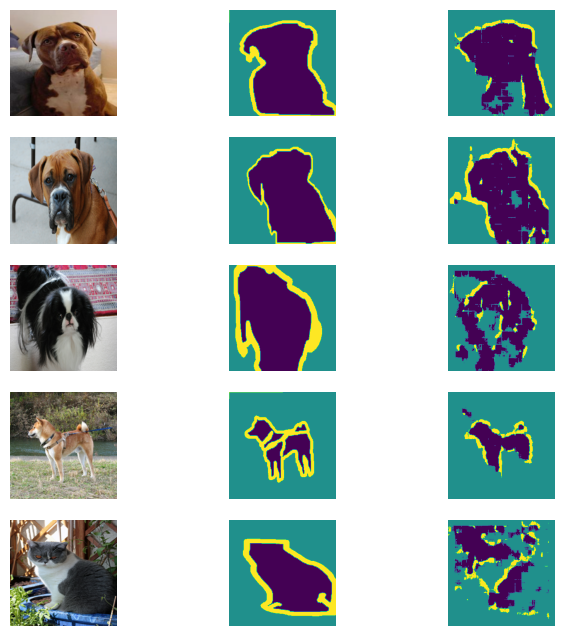

In [ ]:
batch = prediction[1]
showing_images(batch)

In [ ]:
basic_train_loss = history[0]
basic_train_accuracy = history[1]

Text(0.5, 1.0, 'train accuracy')

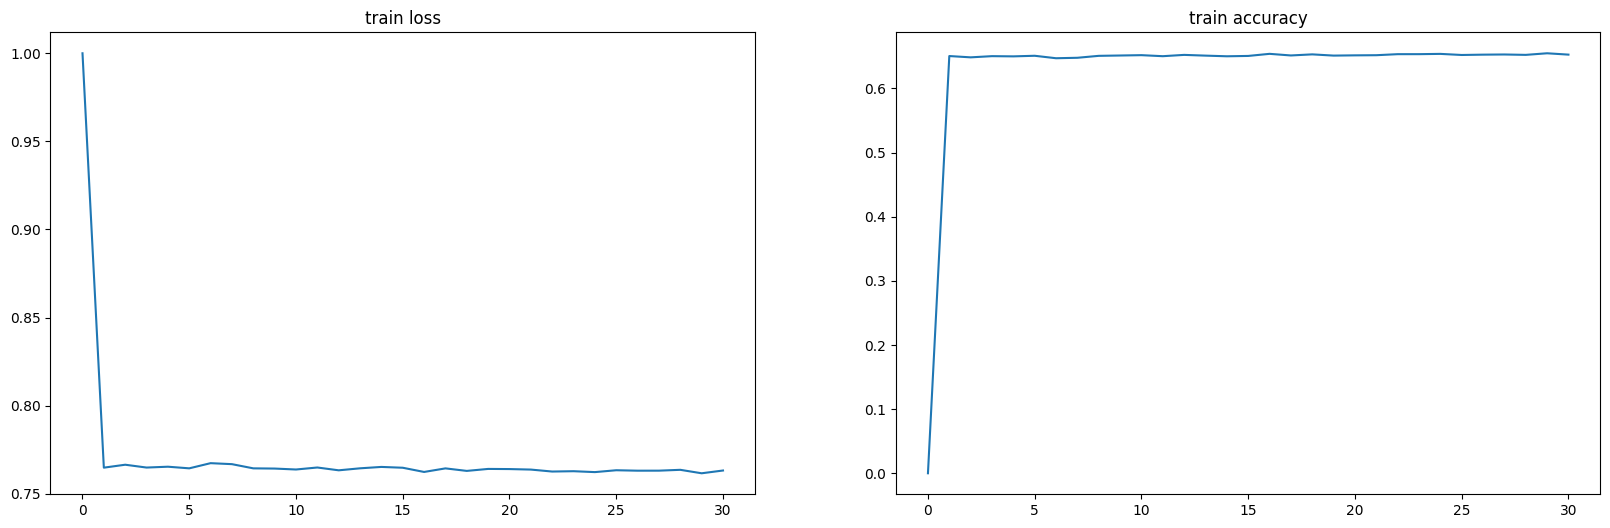

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(basic_train_loss)
plt.title('train loss')
plt.subplot(1, 2, 2)
plt.plot(basic_train_accuracy)
plt.title('train accuracy')

# Better Model

In [ ]:
class BetterModel(nn.Module) :
  def __init__(self):
    super(BetterModel, self).__init__()

    self.layers = torch.nn.Sequential()

    self.layers.add_module('conv1', torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, stride=2))
    self.layers.add_module('norm1', torch.nn.BatchNorm2d(num_features=64))
    self.layers.add_module('relu1', torch.nn.ReLU())
    self.layers.add_module('dropout1', nn.Dropout2d(p=0.1))

    self.layers.add_module('conv2', torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, stride=2))
    self.layers.add_module('norm2', torch.nn.BatchNorm2d(num_features=128))
    self.layers.add_module('relu2', torch.nn.ReLU())
    self.layers.add_module('dropout2', nn.Dropout2d(p=0.1))

    self.layers.add_module('conv3', torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, stride=2))
    self.layers.add_module('norm3', torch.nn.BatchNorm2d(num_features=256))
    self.layers.add_module('relu3', torch.nn.ReLU())
    self.layers.add_module('dropout3', nn.Dropout2d(p=0.1))

    self.layers.add_module('conv4', torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, stride=2))
    self.layers.add_module('norm4', torch.nn.BatchNorm2d(num_features=512))
    self.layers.add_module('relu4', torch.nn.ReLU())
    self.layers.add_module('dropout4', nn.Dropout2d(p=0.1))

    self.layers.add_module('upconv1', torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=1, stride=2, output_padding=1))
    self.layers.add_module('norm5', torch.nn.BatchNorm2d(num_features=256))
    self.layers.add_module('relu5', torch.nn.ReLU())
    self.layers.add_module('dropout5', nn.Dropout2d(p=0.1))

    self.layers.add_module('upconv2', torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=1, stride=2, output_padding=1))
    self.layers.add_module('norm6', torch.nn.BatchNorm2d(num_features=128))
    self.layers.add_module('relu6', torch.nn.ReLU())
    self.layers.add_module('dropout6', nn.Dropout2d(p=0.1))

    self.layers.add_module('upconv3', torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1, stride=2, output_padding=1))
    self.layers.add_module('norm7', torch.nn.BatchNorm2d(num_features=64))
    self.layers.add_module('relu7', torch.nn.ReLU())
    self.layers.add_module('dropout7', nn.Dropout2d(p=0.1))

    self.layers.add_module('upconv4', torch.nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(3, 3), padding=1, stride=2, output_padding=1))
    self.layers.add_module('softmax1', torch.nn.Softmax2d())


  def forward(self, input):
        return self.layers(input)

In [ ]:
better_model = BetterModel()
device = "cuda" if torch.cuda.is_available() else "cpu"
better_model.to(device)

BetterModel(
  (layers): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.1, inplace=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.1, inplace=False)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (dropout3): Dropout2d(p=0.1, inplace=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU()
    (dropout4): Dropout2d(p=0.1, inplace=Fal

In [ ]:
epoch_num = 30
batch_size = 10

In [ ]:
history = trainer(epoch_num, batch_size, train_dataset, better_model, loss_function, optimizer)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

In [ ]:
torch.save(better_model, 'better_model_30_epochs_copy.pkl')

In [ ]:
prediction = predict(5, 5, train_dataset, better_model)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

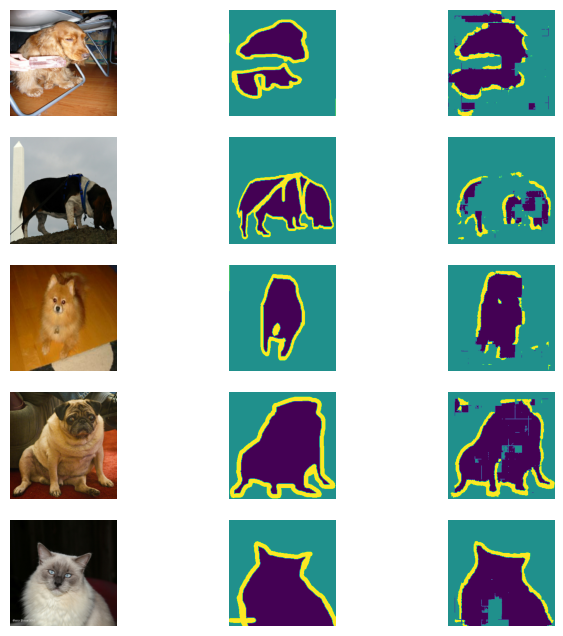

In [ ]:
batch = prediction[1]
showing_images(batch)

In [ ]:
better_train_loss = history[0]
better_train_accuracy = history[1]

Text(0.5, 1.0, 'train accuracy')

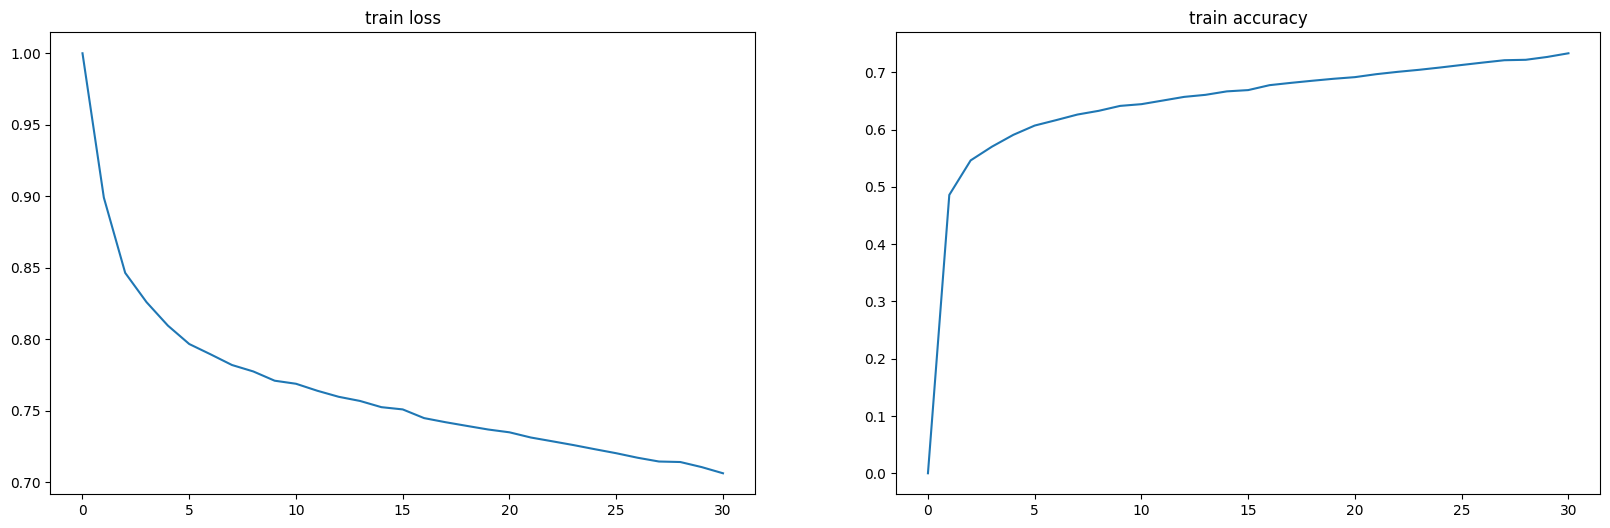

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(better_train_loss)
plt.title('train loss')
plt.subplot(1, 2, 2)
plt.plot(better_train_accuracy)
plt.title('train accuracy')

# Unet Model

In [ ]:
def conv_bn_relu(in_channels, out_channels, kernel=3, stride=1, padding=1):
    net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels,
                  kernel_size=kernel, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )
    return net

In [ ]:
class Stacked2ConvsBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Stacked2ConvsBlock, self).__init__()
        self.blocks = nn.Sequential(
            conv_bn_relu(in_channels, out_channels),
            conv_bn_relu(out_channels, out_channels)
        )

    def forward(self, net):
        net = self.blocks(net)
        return net

In [ ]:
class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSamplingBlock, self).__init__()

        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)

        self.convolve = Stacked2ConvsBlock(2 * in_channels, out_channels)

    def forward(self, left_net, right_net):
        right_net = self.upsample(right_net)
        net = torch.cat((left_net, right_net), dim=1)
        net = self.convolve(net)
        return net

In [ ]:
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSamplingBlock, self).__init__()
        self.blocks = nn.Sequential(
            nn.MaxPool2d(2, 2),
            Stacked2ConvsBlock(in_channels, out_channels)
        )

    def forward(self, net):
        return self.blocks(net)

In [ ]:
class UnetModel(nn.Module):
    def __init__(self):
        super(UnetModel, self).__init__()
        self.init_conv = Stacked2ConvsBlock(3, 64)

        self.downsample_1 = DownSamplingBlock(64, 128)
        self.downsample_2 = DownSamplingBlock(128, 256)
        self.downsample_3 = DownSamplingBlock(256, 512)
        self.downsample_4 = DownSamplingBlock(512, 1024)


        self.upconv = Stacked2ConvsBlock(1024, 512)


        self.upsample_1 = UpSamplingBlock(512, 256)
        self.upsample_2 = UpSamplingBlock(256, 128)
        self.upsample_3 = UpSamplingBlock(128, 64)

        self.upsample_4 = UpSamplingBlock(64, 64)


        self.agg_conv = nn.Sequential(nn.Conv2d(64, 3, kernel_size=1), nn.Sigmoid())

    def forward(self, x):
        net0 = self.init_conv(x) # 3 --> 64

        net1 = self.downsample_1(net0) # 64 --> 128
        net2 = self.downsample_2(net1) # 128 --> 256
        net3 = self.downsample_3(net2) # 256 --> 512
        net = self.downsample_4(net3) # 512 --> 1024

        net = self.upconv(net) # 1024 --> 512

        net = self.upsample_1(net3, net) # 512 --> 256
        net = self.upsample_2(net2, net) # 256 --> 128
        net = self.upsample_3(net1, net) # 128 --> 64
        net = self.upsample_4(net0, net) # 64 --> 64

        net = self.agg_conv(net) # 64 --> 3

        return net

In [ ]:
unet = UnetModel()
device = "cuda" if torch.cuda.is_available() else "cpu"
unet.to(device)

UnetModel(
  (init_conv): Stacked2ConvsBlock(
    (blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (downsample_1): DownSamplingBlock(
    (blocks): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Stacked2ConvsBlock(
        (blocks): Sequential(
          (0): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=

# Unet Training

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [ ]:
epoch_num = 30
batch_size = 10

In [ ]:
train_dataset = AnimalsDataset(train_images, train_masks, mode='train')

In [ ]:
history = trainer(epoch_num, batch_size, train_dataset, unet, loss_function, optimizer)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

In [ ]:
torch.save(unet, 'unet_model_30_epochs_copy.pkl')

In [ ]:
prediction = predict(5, 5, train_dataset, unet)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

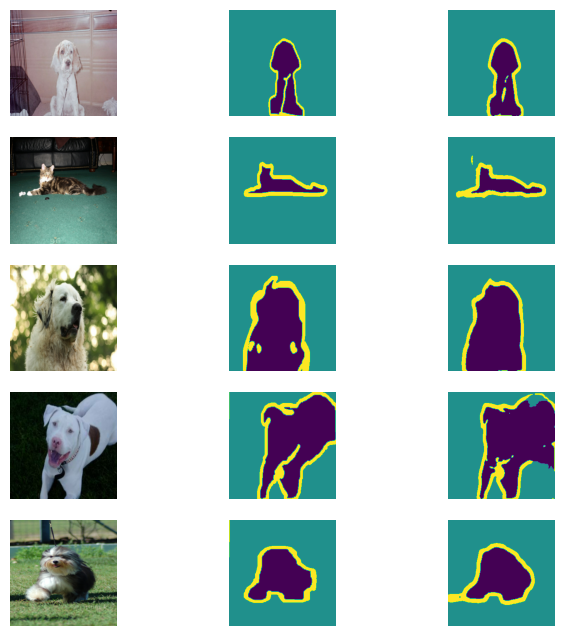

In [ ]:
batch = prediction[1]
showing_images(batch)

In [ ]:
unet_train_loss = history[0]
unet_train_accuracy = history[1]

Text(0.5, 1.0, 'train accuracy')

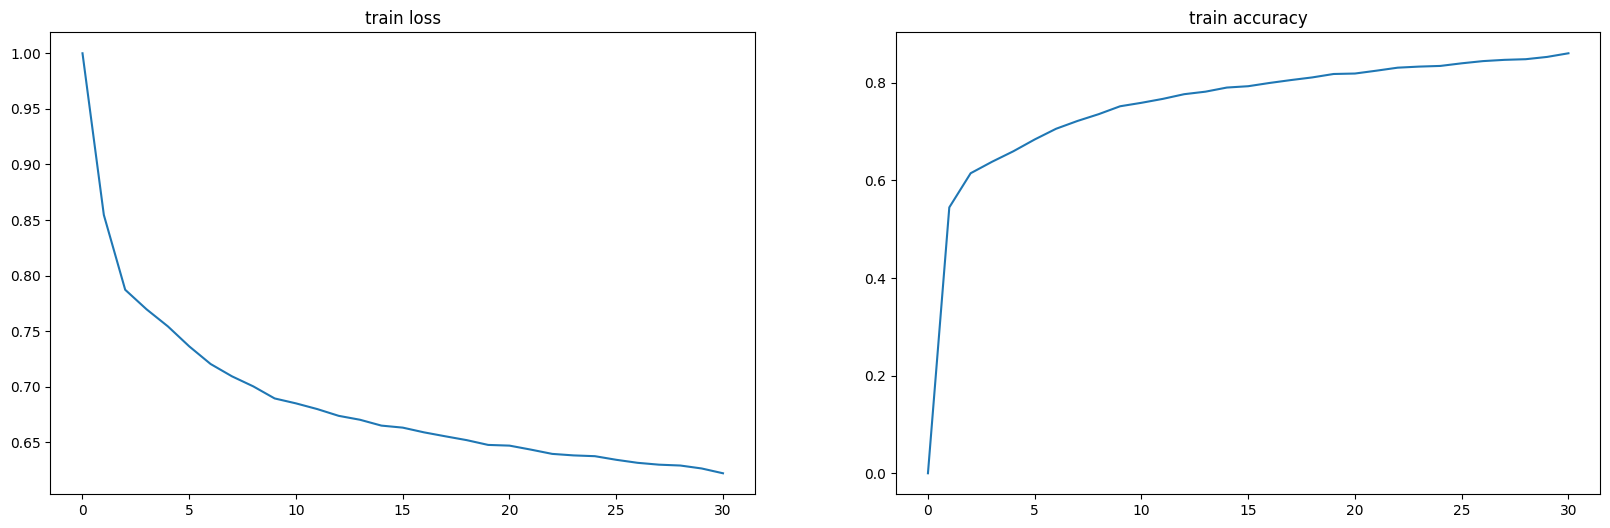

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(unet_train_loss)
plt.title('train loss')
plt.subplot(1, 2, 2)
plt.plot(unet_train_accuracy)
plt.title('train accuracy')

# Compairing results

In [ ]:
def pred_test_epoch(batch_generator, model):
    for it, batch_of_x in enumerate(batch_generator):
        output = pred_on_batch(model, batch_of_x.to(device))
        predict = {'img' : batch_of_x, 'pred_mask' : output}
    return predict

In [ ]:
def test_predict(count_of_epoch,
            batch_size,
            dataset,
            model):

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    prediction = []
    for it in iterations:
        batch_generator = tqdm(torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False),
                               leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        prediction.append(pred_test_epoch(batch_generator,
                    model=model))
    return prediction

In [ ]:
def showing_test_images(prediction) :
  size = len(prediction['img'])
  fig = plt.figure(figsize=(8, 8))
  gs = gridspec.GridSpec(size, 3)
  ax = np.empty([size, 3], dtype=object)
  for i in range(size):
    for j in range(2):
      ax[i][j] = fig.add_subplot(gs[i, j])
      ax[i][j].axis("off")
  for i in range(size):
    special_rgb_imshow(prediction['img'][i], plt_ax=ax[i][0])
    special_bw_imshow(prediction['pred_mask'][i], plt_ax=ax[i][1])

In [ ]:
test_dataset = AnimalsDataset(test_images, test_masks, mode='test')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Segmentation/basic.txt', 'w') as basic_f:
  basic_f.write("Loss: \n")
  basic_f.write(str(basic_train_loss))
  basic_f.write("\n")
  basic_f.write("Accuracy: \n")
  basic_f.write(str(basic_train_accuracy))

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Segmentation/better.txt', 'w') as better_f:
  better_f.write("Loss: \n")
  better_f.write(str(better_train_loss))
  better_f.write("\n")
  better_f.write("Accuracy: \n")
  better_f.write(str(better_train_accuracy))

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Segmentation/unet.txt', 'w') as unet_f:
  unet_f.write("Loss: \n")
  unet_f.write(str(unet_train_loss))
  unet_f.write("\n")
  unet_f.write("Accuracy: \n")
  unet_f.write(str(unet_train_accuracy))

In [ ]:
#basic_model = Model()
#device = "cuda" if torch.cuda.is_available() else "cpu"
#basic_model.to(device)
basic_model = torch.load('/content/drive/My Drive/Colab Notebooks/Segmentation/basic_model_30_epochs_copy.pkl', map_location=torch.device('cuda'))

In [ ]:
better_model = torch.load('/content/drive/My Drive/Colab Notebooks/Segmentation/better_model_30_epochs_copy.pkl', map_location=torch.device('cuda'))

In [ ]:
unet_model = torch.load('/content/drive/My Drive/Colab Notebooks/Segmentation/unet_model_30_epochs_copy.pkl', map_location=torch.device('cuda'))

In [ ]:
basic_prediction = test_predict(1, 10, test_dataset, basic_model)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

In [ ]:
better_prediction = test_predict(1, 10, test_dataset, better_model)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

In [ ]:
unet_prediction = test_predict(1, 10, test_dataset, unet_model)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

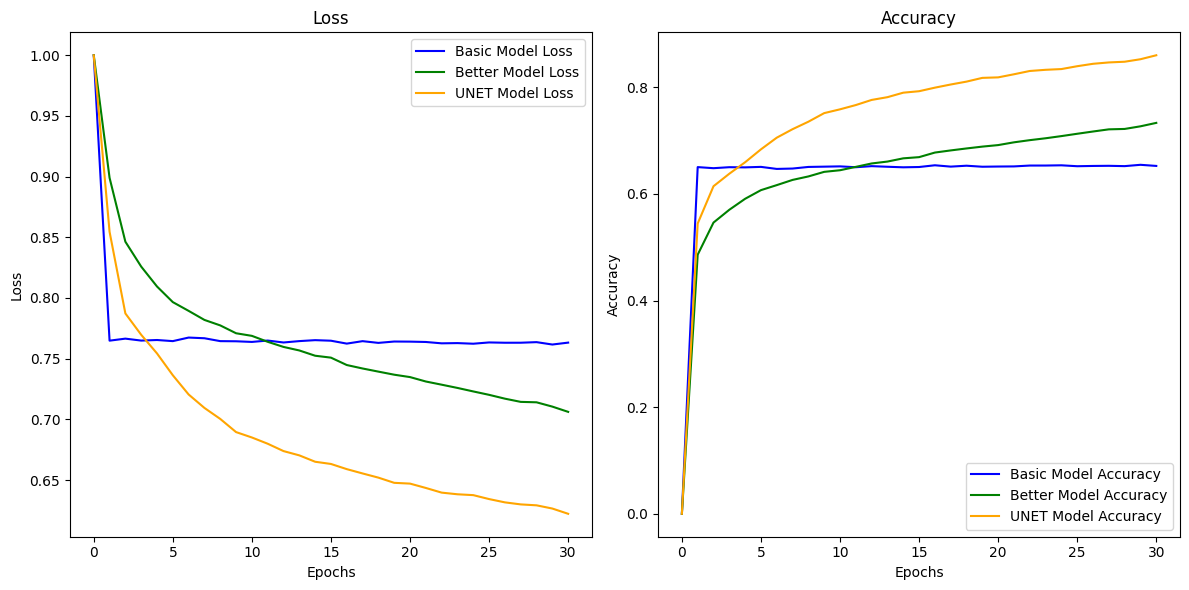

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(basic_train_loss, color='blue', label='Basic Model Loss')
plt.plot(better_train_loss, color='green', label='Better Model Loss')
plt.plot(unet_train_loss, color='orange', label='UNET Model Loss')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for accuracy
plt.subplot(1, 2, 2)

plt.plot(basic_train_accuracy, color='blue', label='Basic Model Accuracy')
plt.plot(better_train_accuracy, color='green', label='Better Model Accuracy')
plt.plot(unet_train_accuracy, color='orange', label='UNET Model Accuracy')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("Loss and Accuracy.pdf")
plt.show()

In [ ]:
def final_showing_test_images(basic_prediction, better_prediction, unet_prediction) :
  size = len(basic_prediction['img'])
  fig = plt.figure(figsize=(8, 8))
  gs = gridspec.GridSpec(size, 4)
  ax = np.empty([size, 4], dtype=object)
  for i in range(size):
    for j in range(4):
      ax[i][j] = fig.add_subplot(gs[i, j])
      ax[i][j].axis("off")
  for i in range(size):
    special_rgb_imshow(basic_prediction['img'][i], plt_ax=ax[i][0])
    special_bw_imshow(basic_prediction['pred_mask'][i], plt_ax=ax[i][1])
    special_bw_imshow(better_prediction['pred_mask'][i], plt_ax=ax[i][2])
    special_bw_imshow(unet_prediction['pred_mask'][i], plt_ax=ax[i][3])

In [ ]:
basic_pred = basic_prediction[0]
better_pred = better_prediction[0]
unet_pred = unet_prediction[0]

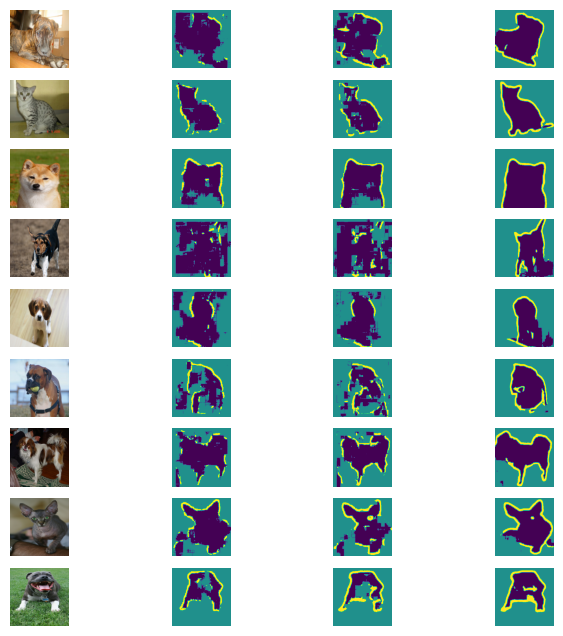

In [ ]:
final_showing_test_images(basic_pred, better_pred, unet_pred)